# Calibrate exact tellurics from A0V

The resolution seems off.  Let's calibrate blasé with the LFC spectra.

In [1]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np
from specutils import Spectrum1D
import os

import seaborn as sns

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

Woohoo! You have a version 1.11.0+cu102 of PyTorch


In [2]:
device

'cuda'

## Get Real data with unknown signals

In [3]:
from muler.hpf import HPFSpectrum

Select an A0V standard star

LFC calibrator:   
#/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20220623T082120_v1.0_0005.spectra.fits

In [4]:
fn = '/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20220623T033933_v1.0_0001.spectra.fits'

In [5]:
if not os.path.exists(fn):
    fn = '../../data/HPF/demo/Goldilocks_20220623T033933_v1.0_0001.spectra.fits'

In [6]:
! ls ../../../disperse/data/HPF/CALS/Goldilocks_20210801T063539_v1.0_0026.spectra.fits

../../../disperse/data/HPF/CALS/Goldilocks_20210801T063539_v1.0_0026.spectra.fits


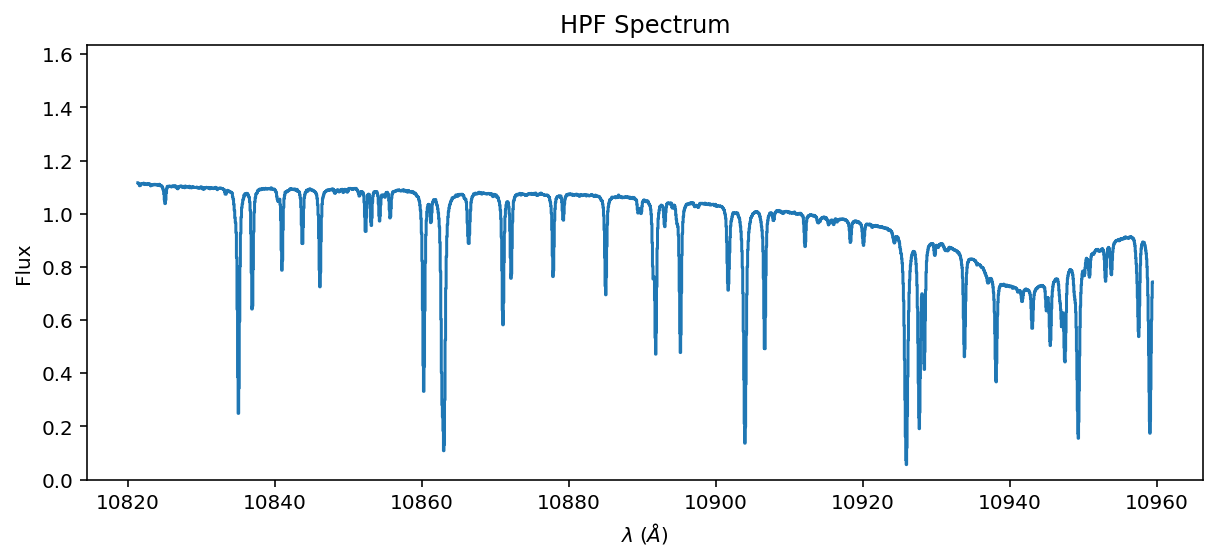

In [7]:
spec = HPFSpectrum(file=fn)

spec = spec.sky_subtract().trim_edges((10, 2048)).remove_nans().deblaze().normalize()
ax = spec.plot()

In [ ]:
spec = spec_list.normalize().stitch()#HPFSpectrum(file=file, order=19)

In [8]:
wl_lo = 10820-30.0
wl_hi = 10960+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

In [9]:
spec.meta['header']['OBJECT']

'HR4828_tell_std'

In [10]:
from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid

In [11]:
#grid = PHOENIXGrid(teff_range=(9_000, 11_000), logg_range=(3,5), Z_range=(-0.5, 0.5), wl_lo=10770, wl_hi=11010)

In [12]:
RV_alt = spec.estimate_barycorr().to(u.km/u.s).value - 5.08 # from Gaia DR3!

In [13]:
RV_alt

-33.672478647958776

In [14]:
vsini_init = 118.80
RV_init = 41.9
teff_init=9_400
logg_init=4.0

In [15]:
template = PHOENIXSpectrum(teff=teff_init, logg=logg_init, wl_lo=10770, wl_hi=11010)\
            .rotationally_broaden(vsini_init)\
            .rv_shift(-RV_alt)\
            .normalize()

In [16]:
scalar = np.percentile(spec.flux, 99)
spec = spec.divide(scalar, handle_meta='ff')
scalar = np.percentile(template.flux, 99)
template = template.divide(scalar, handle_meta='ff')

In [17]:
template = template.resample(spec)

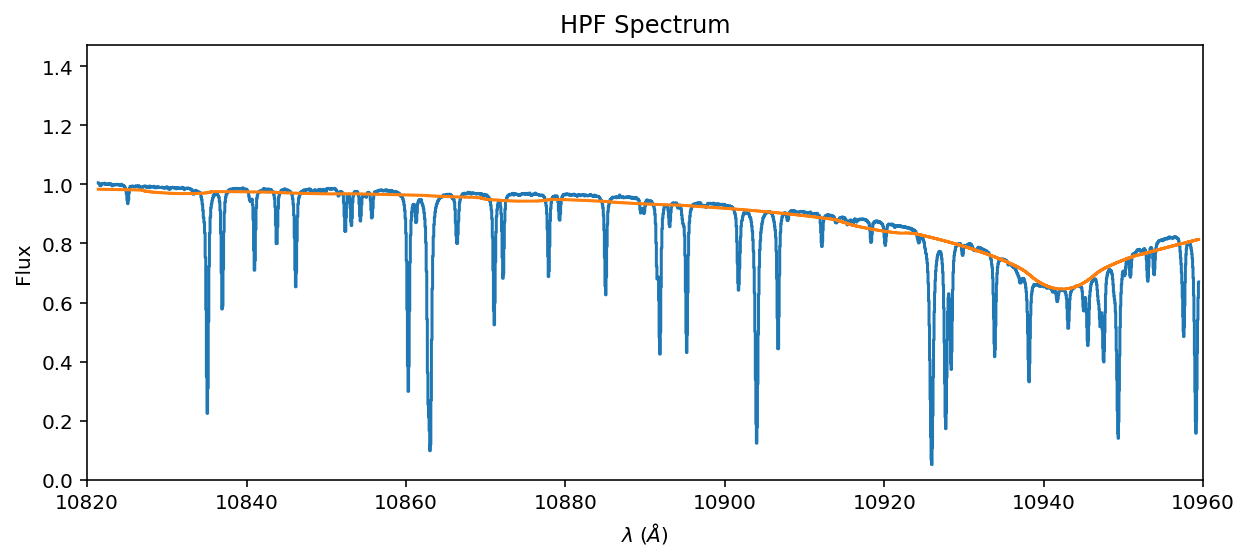

In [18]:
ax = spec.plot()
template.plot(ax=ax)
ax.set_xlim(10820, 10960);

In [19]:
spectrum = spec

In [20]:
spectrum.bin_edges

<Quantity [10821.35515741, 10821.43418663, 10821.51321086, ...,
           10959.3483403 , 10959.40456759, 10959.46078881] Angstrom>

In [21]:
guess_sigma = 0.1
guess_gamma = 0.05

## Model the (broad) stellar lines with blase

In [22]:
from blase.emulator import SparseLogEmulator

In [23]:
native_template = PHOENIXSpectrum(teff=teff_init, logg=logg_init, wl_lo=wl_lo, wl_hi=wl_hi).normalize()

In [24]:
star = SparseLogEmulator(native_template.wavelength.value, np.log(native_template.flux.value),
                             wing_cut_pixels=6000, prominence=0.01, device=device)

/home/gully/GitHub/blase/src/blase/emulator.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 17 spectral lines


In [25]:
star.to(device)

SparseLogEmulator()

## Model the lines with blasé

In [26]:
from gollum.telluric import TelFitSpectrum

### Guess and check

In [27]:
#local_file = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp290_hum040.txt'
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [28]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()

In [29]:
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) &
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

In [30]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`

In [31]:
telluric_lnflux[telluric_lnflux < -15] = -15

In [32]:
emulator = SparseLogEmulator(telluric_wl, telluric_lnflux,
                             wing_cut_pixels=6000, prominence=0.01, device=device)

Initializing a sparse model with 62 spectral lines


/home/gully/GitHub/blase/src/blase/emulator.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


In [33]:
emulator.to(device)

SparseLogEmulator()

In [34]:
with torch.no_grad():
    telluric_pre = emulator.forward().cpu().numpy()

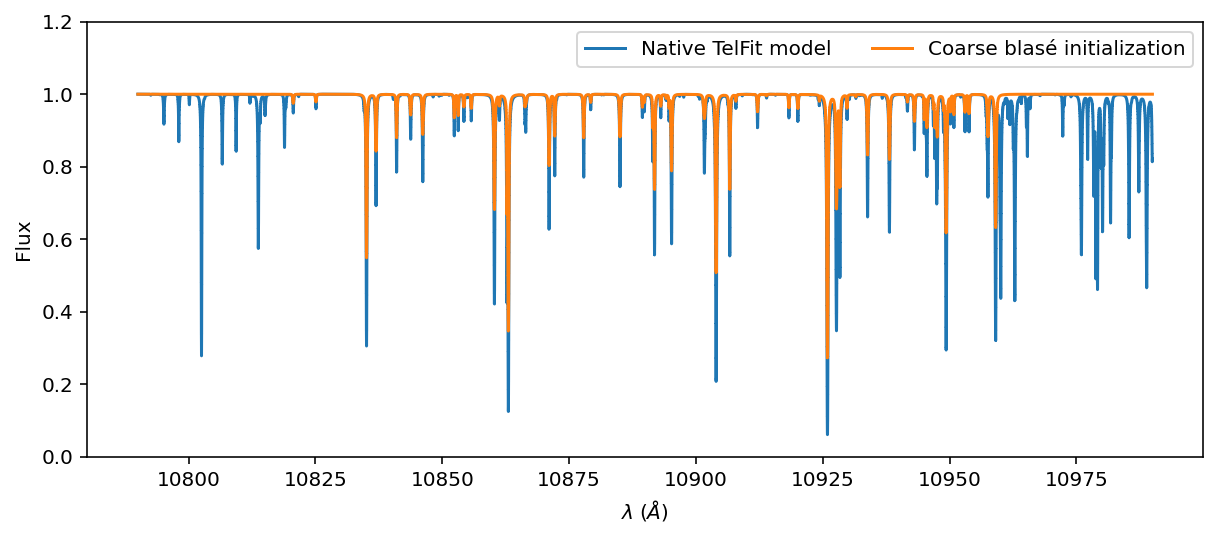

In [35]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_pre, label='Coarse blasé initialization')
ax.legend(loc='upper right', ncol=2);

In [36]:
emulator.lam_centers.requires_grad = True
emulator.amplitudes.requires_grad = True
emulator.sigma_widths.requires_grad = True
emulator.gamma_widths.requires_grad = True

In [40]:
emulator.optimize(epochs=200, LR=0.05)

Training Loss: 0.00000487: 100%|██████| 200/200 [00:05<00:00, 34.45it/s]


In [41]:
with torch.no_grad():
    telluric_post = emulator.forward().cpu().numpy()

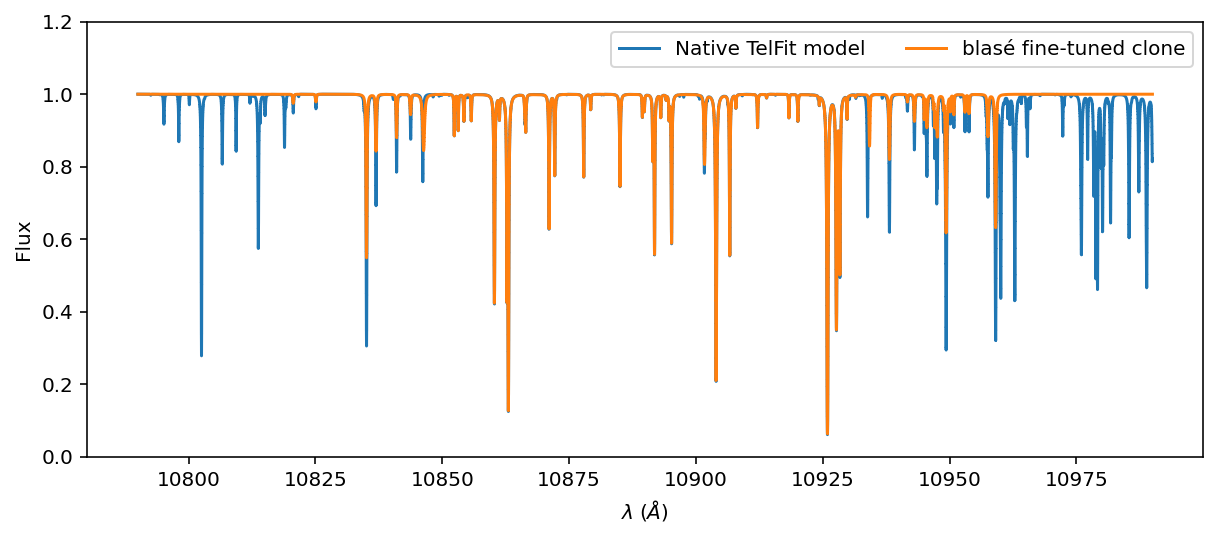

In [42]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_post, label='blasé fine-tuned clone')
ax.legend(loc='upper right', ncol=2);

#### Instrumental model

In [43]:
instrumental_model = InstrumentalModel(spectrum.bin_edges.value, telluric_wl, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [44]:
#instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [45]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [46]:
data_target = torch.tensor(
    spectrum.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    spectrum.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [47]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [48]:
emission_model = emulator

In [49]:
# Fix all stellar parameters except amplitude and RV
emission_model.amplitudes.requires_grad = True
emission_model.radial_velocity.requires_grad = False
emission_model.lam_centers.requires_grad = True
emission_model.sigma_widths.requires_grad = True
emission_model.gamma_widths.requires_grad = True
emission_model.a_coeff.requires_grad = True
emission_model.b_coeff.requires_grad = True
emission_model.c_coeff.requires_grad = True

# Fix all instrument parameters
instrumental_model.ln_sigma_angs.requires_grad = False
instrumental_model.linear_model.weight.requires_grad = False
instrumental_model.linear_model.bias.requires_grad = False

In [50]:
tuning_params = list(filter(lambda p: p.requires_grad, emission_model.parameters()))

In [51]:
optimizer = optim.Adam(tuning_params,0.05,amsgrad=True)         

In [82]:
n_epochs = 300
losses = []

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [83]:
#per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

In [84]:
with torch.no_grad():
    instrumental_model.instrumental_broaden(flux, 0.04).shape

In [85]:
flux.shape

torch.Size([83123])

In [86]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    emission_model.train()
    instrumental_model.train()
    
    flux = emission_model.forward()
    detector_flux = instrumental_model.resample_to_data(flux)
    
    loss = loss_fn(detector_flux, data_target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 0.00010750: 100%|██████████████| 300/300 [00:22<00:00, 13.44it/s]


### Spot check the transfer-learned joint model

In [87]:
residual = spectrum.flux - detector_flux.detach().cpu().numpy()

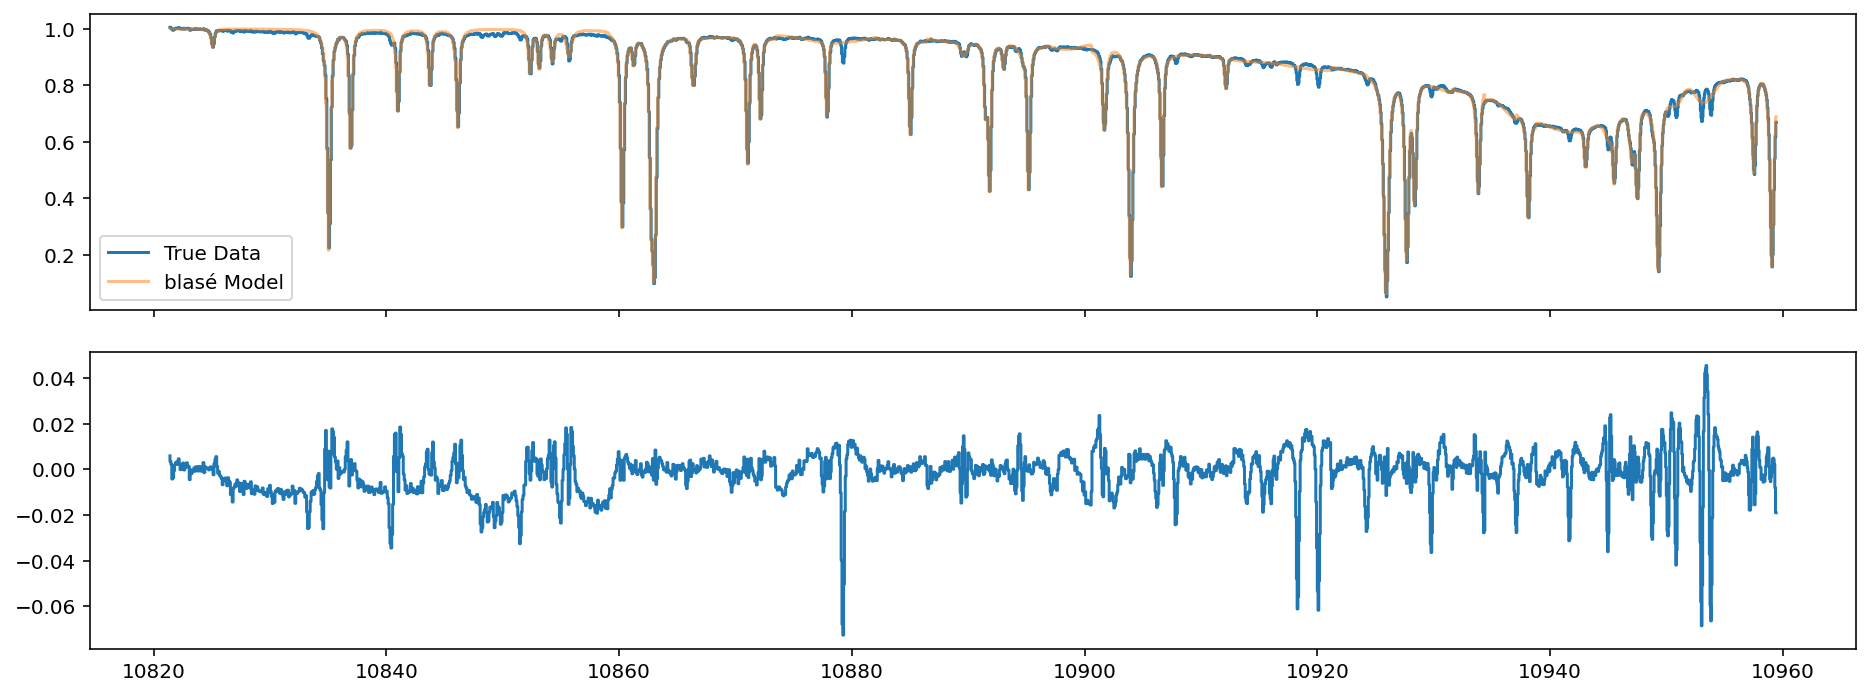

In [88]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5);
ax2.step(spectrum.wavelength,residual)
ax1.legend();

Hooray! We match the data pretty well!

In [89]:
np.std(residual)

<Quantity 0.01023605>

(10820.0, 10880.0)

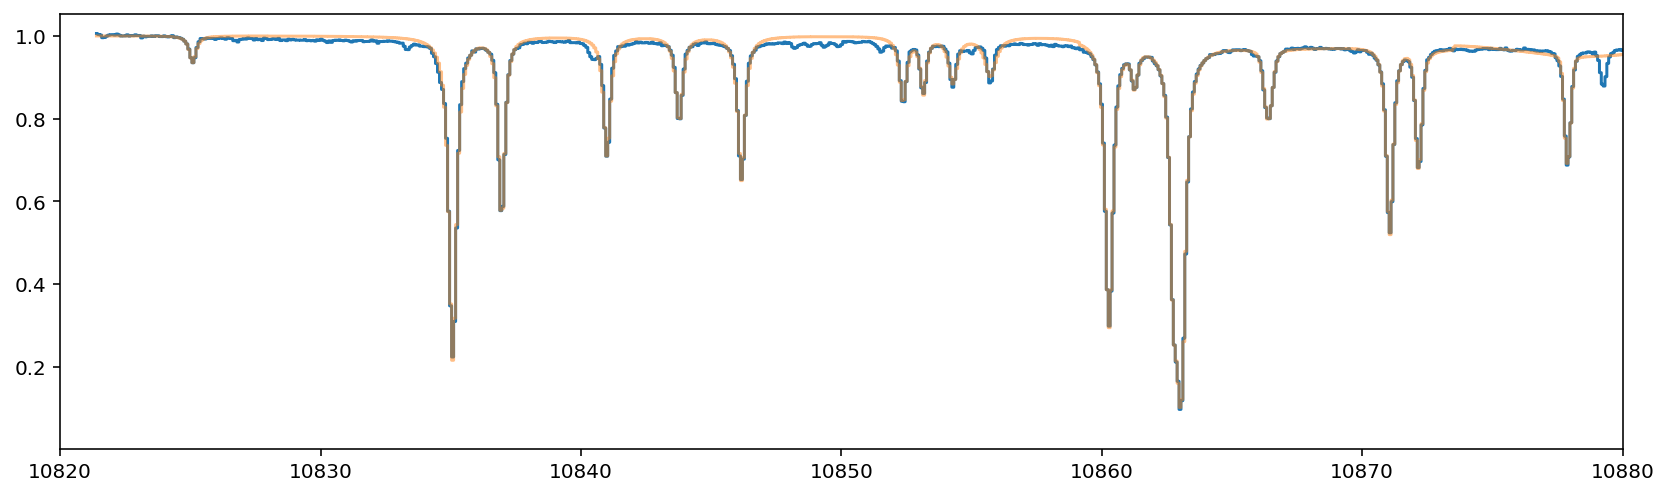

In [93]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid');
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid', alpha=0.5);
ax.set_xlim(10820, 10880)

Looks great, albeit not perfect-- we are resampling spectra, which should have an effect here...